In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc, f1_score, precision_score
import numpy as np
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
data = pd.read_csv('data/all/train/0D0.csv')
valid_data = pd.read_csv('data/all/validation/0D0_3.csv')

time_series = data['Time'].values.reshape(-1, 1)

time_intervals = np.diff(data['Time'])

scaler = MinMaxScaler()
# normalized_intervals = scaler.fit_transform(time_intervals.reshape(-1, 1))
normalized_intervals = time_intervals.reshape(-1, 1)

In [18]:
def create_dataset(data, timesteps):
    X = []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
    return np.array(X)

timesteps = 1
X_train = create_dataset(normalized_intervals, timesteps)

In [ ]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(1))(L5)  # 修改输出维度为1
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

In [20]:
model.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
3519/3519 [==============================] - 79s 22ms/step - loss: 9.5512e-04 - val_loss: 2.0711e-04
Epoch 2/10
3519/3519 [==============================] - 79s 23ms/step - loss: 2.3324e-04 - val_loss: 5.9440e-04
Epoch 3/10
3519/3519 [==============================] - 79s 22ms/step - loss: 2.1034e-04 - val_loss: 3.8538e-04
Epoch 4/10
3519/3519 [==============================] - 78s 22ms/step - loss: 2.0440e-04 - val_loss: 3.6757e-04
Epoch 5/10
3519/3519 [==============================] - 75s 21ms/step - loss: 1.8796e-04 - val_loss: 1.0709e-04
Epoch 6/10
3519/3519 [==============================] - 75s 21ms/step - loss: 1.9357e-04 - val_loss: 1.8515e-04
Epoch 7/10
3519/3519 [==============================] - 76s 22ms/step - loss: 1.9811e-04 - val_loss: 8.0449e-05
Epoch 8/10
3519/3519 [==============================] - 77s 22ms/step - loss: 1.9370e-04 - val_loss: 3.2447e-04
Epoch 9/10
3519/3519 [==============================] - 76s 22ms/step - loss: 1.8847e-04 - val_loss: 1.9

In [21]:
predictions = model.predict(X_train)

# predict_y = predictions[:, 9, :]
predict_y = predictions[:, 0, :]

3910/3910 [==============================] - 17s 4ms/step


In [22]:
train_error = np.abs(predict_y - X_train[:, 0, :])
train_error.shape

(125093, 1)

In [23]:
valid_data = pd.read_csv('data/all/validation/0D0_3.csv')
valid_intervals = valid_data['Time'].diff().dropna()
case_numbers = valid_data.index[1:].values
valid_intervals

np.diff(valid_data['Time']).mean()

0.00733554735152488

In [24]:
predictions.shape

valid_intervals

1       0.009053
2       0.014074
3       0.006487
4       0.010501
5       0.009529
          ...   
7472    0.011040
7473    0.009357
7474    0.012109
7475    0.008130
7476    0.010720
Name: Time, Length: 7476, dtype: float64

In [ ]:
abnormals = []
is_attack_predicted = []
tmp_len = 0
for i in range(len(valid_intervals)):
    # thr = predict_y.reshape(-1)[i] - 10 * np.mean(train_error)
    thr = predict_y.reshape(-1)[i] - 3 * np.std(predict_y.reshape(-1))
    value = valid_intervals.values[i]
    if tmp_len != 0:
        value += tmp_len
        tmp_len = 0
    if value < thr:
        abnormals.append(case_numbers[i])
        is_attack_predicted.append(1)
        tmp_len = valid_intervals.values[i]
    else:
        is_attack_predicted.append(0)

print(len(abnormals))

In [26]:
valid_data['is_attack'] = valid_data['Label'].apply(lambda x: 0 if x == 'Normal' else 1)

In [27]:
valid_data['is_attack'].sum()

2001

In [ ]:
is_attack_actual = valid_data['is_attack'].values[1:] # 对其处理数据时的索引差异

conf_matrix = confusion_matrix(is_attack_actual, is_attack_predicted)
print("混淆矩阵:")
print(conf_matrix)

f1 = f1_score(is_attack_actual, is_attack_predicted)
print(f"F1 分数: {f1}")

recall = recall_score(is_attack_actual, is_attack_predicted)
print(f"召回率: {recall}")

accuracy = precision_score(is_attack_actual, is_attack_predicted)
print(f"准确率: {accuracy}")

precision = precision_score(is_attack_actual, is_attack_predicted)
print(f"精确率 (Precision): {precision}")

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attack', 'Attack'], yticklabels=['No Attack', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

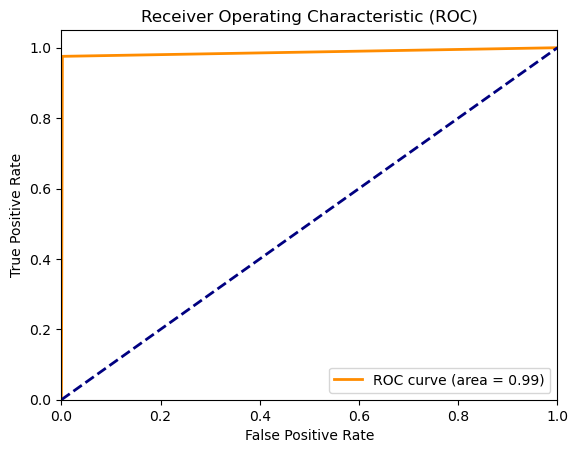

Accuracy: 0.9943963321446765
Recall: 0.975512243878061
Confusion Matrix:
[[5464   11]
 [  49 1952]]


In [30]:
fpr, tpr, _ = roc_curve(is_attack_actual, is_attack_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")